Here we give birth to an smarter agent, that takes the last two notes and needs to guess the following one. It uses standard Q-learning (1 step in the future), and its reward is given according to the distance of that note.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from tqdm import tqdm
import os
import pandas as pd

class Record:
    def __init__(self, T_0, notes_to_choose = 5):
        self.notes_to_choose = notes_to_choose
        self.transitions = [T_0]
        self.trajectories = []
    

In [81]:
       
class Agent():
    def __init__(self, notes_to_choose, gamma=0., ep=0.01, index=0, lowest_key=0, reward_distance=True):
        
        
        self.index = index
        
        k=0
        self.ind_to_state={}
        self.state_to_ind={}
        for i1 in range(notes_to_choose):
            for i2 in range(notes_to_choose):
                state = [i1,i2]
                self.ind_to_state[str(k)] = state
                self.state_to_ind[str(state)] = k
                k+=1
        
        self.n_actions = notes_to_choose
        
        self.q = np.ones((k, notes_to_choose))
        self.n = np.ones((k, notes_to_choose))
        
        self.lowest_key=lowest_key ##this will shift the scale of 12 notes
        
        self.epsilon = ep
        self.gamma = gamma
        self.reward_distance=reward_distance
            
        self.qtables_history=[]
        self.reward_history=[]
        self.trajectories=[]
    
        self.notes_to_state = lambda melody, ind1, ind2: [melody[ind1], melody[ind2]]

        self.peaked_reward = 1
        self.lr_min = 1
        np.random.seed(self.index)
        
    def give_action(self, state, greedy=False):
        if np.random.random()<self.epsilon and (greedy == False):
            return np.random.choice(range(self.n_actions), 1)[0]
        else:
            qs = self.q[state,:]
            qs = np.where( qs == np.max(qs) )[0]
            return np.random.choice(qs, 1)[0]

    def get_reward(self, guess, label):
        if self.reward_distance is True:
            d = np.abs(guess-label)
            return np.exp(-self.peaked_reward*d/self.n_actions)
        else:
            if guess == label:
                return 1
            else:
                return 0
    def get_interesting_q(self):
        interesting_q=[]
        q=self.q.copy()
        for k in q:
            if np.std(k)<1e-2:
                pass
        else:
            interesting_q.append(k)
        return np.array(interesting_q)
    
    def q_learn(self, ts):
        self.qtables_history.append(self.get_interesting_q())
        for interaction in ts:
            s, a, r, ns = interaction
            self.reward_history.append(r)
            self.n[s,a]+=1
            lr=np.clip(1/self.n[s,a],0,self.lr_min)
            
            td_target =  r + np.clip(np.max(self.q[ns,:]) , 0, self.gamma)
            self.q[s,a] += (td_target- self.q[s,a])*lr
        
    def decrease_ep(self,ind, tau=100):
        self.epsilon = max(self.epsilon*np.exp(-(ind+1)/tau), 0.1)
        if ind>50:
            self.reward_distance=False
        return
    
    def give_melody(self, melody):
        note_player=[]
        for ind,note in enumerate(melody):
            note_player.append(self.give_action(note, greedy=True))
        return note_player
    
    def learn_melody(self, melody, N=50):
        #in case the melody is more agudo (we always keep to 12 notes)
        self.target_melody = melody
        melody = np.array(melody)-self.lowest_key
        for episode in tqdm(range(N)):
            ts=[]
            trajectory=[]
            indM=-2
            state = agent.notes_to_state(melody, indM, indM+1)
            state_id = agent.state_to_ind[str(state)]
            for target_note in melody:
                action = agent.give_action(state_id)
                trajectory.append(action)
                reward = agent.get_reward(target_note, action)
                indM+=1
                next_state = agent.notes_to_state(melody, indM, indM+1)
                next_state_id = agent.state_to_ind[str(next_state)]
                ts.append([state_id, action, reward, next_state_id])
                state_id = next_state_id
            
            self.q_learn(ts)
            self.decrease_ep(episode)
            self.trajectories.append(np.array(trajectory) + self.lowest_key)
            
    def get_cumulative(self):
        return np.cumsum(self.reward_history)/np.arange(1,len(self.reward_history)+1)
    
    def get_learning_curve(self):
        plt.figure(figsize=(10,10))
        plt.title("Learning curve\ntarget melody: {} \nfinal melody played {}".format(self.target_melody, self.trajectories[-1]), size=20)
        plt.plot(self.get_cumulative(), linewidth=15, alpha=0.7,color="red")
        plt.xlabel("Episodes",size=30)
        plt.ylabel("Cumulative rewards", size=30)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.ylim([0,1])

## Q-learning + reward-distance

How long till you get the correct sequence? Note that rewarding w/ distance not always result in exactly the correct melody (which can be undesirable).

100%|██████████| 400/400 [00:01<00:00, 355.05it/s]


[array([0, 3, 5, 3, 0]), array([0, 3, 5, 3, 0]), array([0, 3, 5, 3, 0]), array([0, 3, 5, 3, 0]), array([0, 3, 5, 3, 0]), array([0, 3, 5, 3, 0]), array([0, 5, 5, 3, 0]), array([0, 3, 5, 3, 0]), array([0, 3, 5, 3, 0]), array([ 0,  3,  5,  3, 11])]


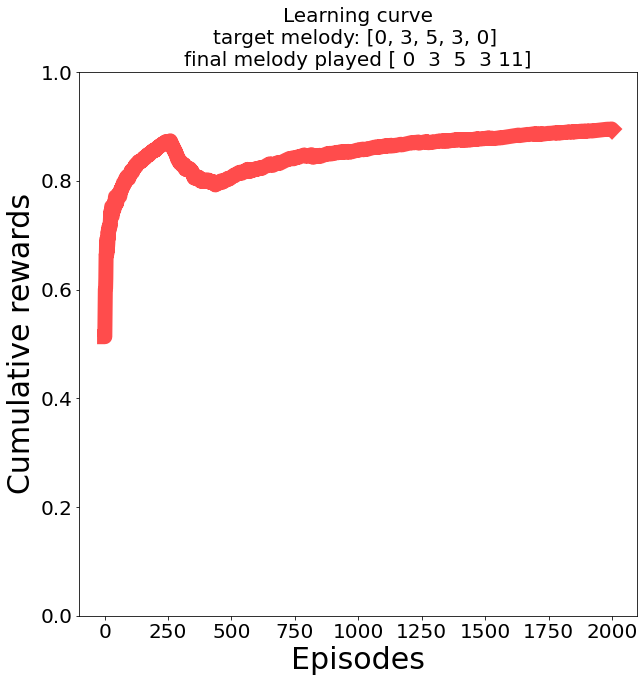

In [88]:
for k,temps in enumerate([400]):
    agent = Agent(12, ep=1, gamma=1, reward_distance=True, index=1)
    melody = list(np.array([0,3,5,3,0]) + 0)
    agent.learn_melody(melody,N=temps)
    agent.get_learning_curve()
    print(agent.trajectories[-10:])

100%|██████████| 400/400 [00:01<00:00, 351.54it/s]


[array([3, 6, 8, 6, 3]), array([3, 6, 8, 6, 3]), array([3, 6, 8, 6, 3]), array([3, 6, 8, 6, 3]), array([3, 6, 8, 6, 3]), array([3, 6, 8, 6, 3]), array([3, 8, 8, 6, 3]), array([3, 6, 8, 6, 3]), array([3, 6, 8, 6, 3]), array([ 3,  6,  8,  6, 14])]


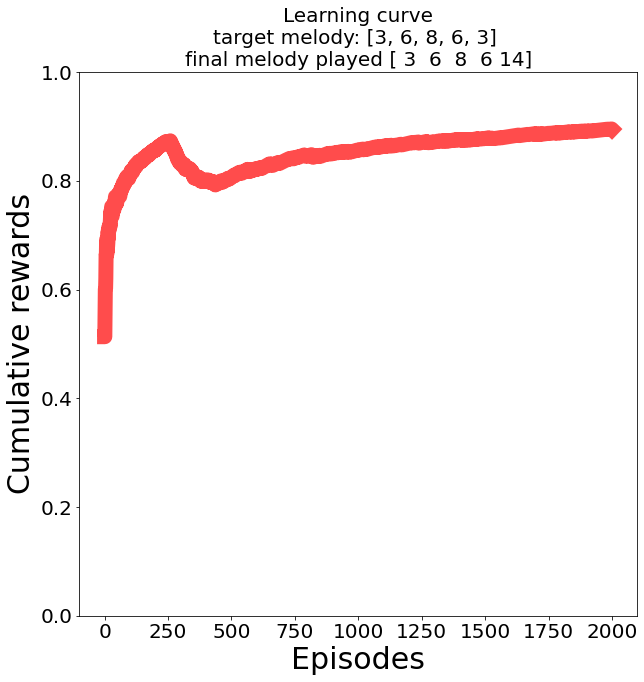

In [89]:
for k,temps in enumerate([400]):
    agent = Agent(12, ep=1, gamma=1, reward_distance=True, index=1, lowest_key=3)
    melody = list(np.array([0,3,5,3,0]) + 3)
    agent.learn_melody(melody,N=temps)
    agent.get_learning_curve()
    print(agent.trajectories[-10:])

100%|██████████| 400/400 [00:01<00:00, 362.04it/s]


[array([ 5,  8, 10,  8,  5]), array([ 5,  8, 10,  8,  5]), array([ 5,  8, 10,  8,  5]), array([ 5,  8, 10,  8,  5]), array([ 5,  8, 10,  8,  5]), array([ 5,  8, 10,  8,  5]), array([ 5, 10, 10,  8,  5]), array([ 5,  8, 10,  8,  5]), array([ 5,  8, 10,  8,  5]), array([ 5,  8, 10,  8, 16])]


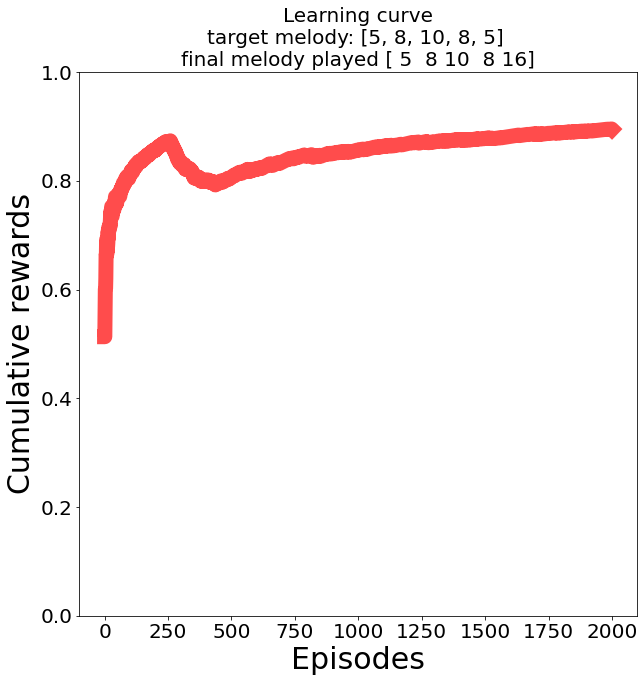

In [90]:
for k,temps in enumerate([400]):
    agent = Agent(12, ep=1, gamma=1, reward_distance=True, index=1, lowest_key=5)
    melody = list(np.array([0,3,5,3,0]) + 5)
    agent.learn_melody(melody,N=temps)
    agent.get_learning_curve()
    print(agent.trajectories[-10:])

## Up to now, oki doki

In [ ]:
for k,temps in enumerate([1000]):
    agent = Agent(12, ep=1, gamma=1, reward_distance=True)
    melody = [0,4,7,4,0]
    agent.learn_melody(melody,N=temps)
    agent.get_learning_curve()

In [75]:
NTrain=400
agents = {}
major=[0,3,5]
minor=[0,2,5]
for ind in range(1,3):
    agents[ind] = Agent(12, ep=1,  gamma=1, index=ind, lowest_key=major[ind], reward_distance=True)
    agents[ind].target_melody = list(np.array([0,3,5,3,0])+major[ind])
    agents[ind].learn_melody(agents[ind].target_melody,N=NTrain)

100%|██████████| 400/400 [00:01<00:00, 343.46it/s]


In [76]:
agents[2].trajectories[-1]

array([ 5,  8, 10,  8,  5])

In [34]:
for agent in agents.values():
    os.makedirs("AIdata/agent{}/".format(agent.index), exist_ok=True)
    for ind, traj in enumerate(agent.trajectories):
        np.savetxt("AIdata/agent{}/episode{}.csv".format(agent.index, ind),np.array([traj]).astype(int)+60, fmt='%i', delimiter=",")

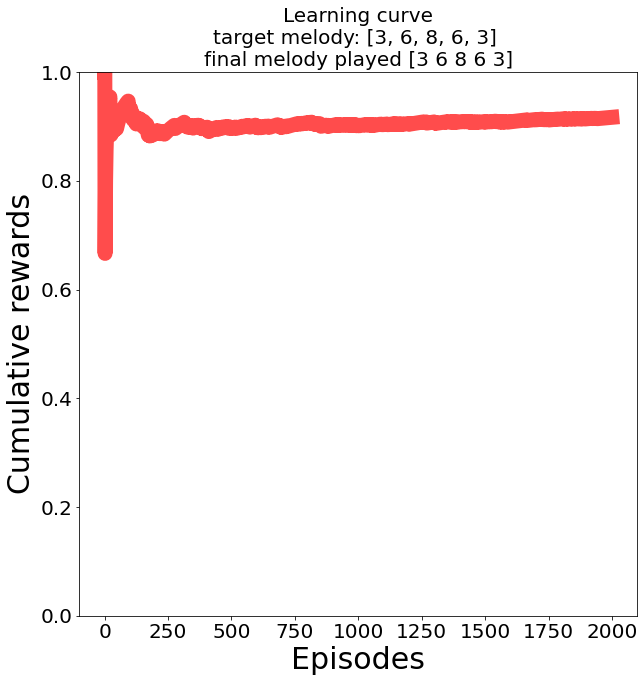

In [77]:
agents[1].get_learning_curve()

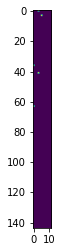

In [79]:
plt.imshow(agents[1].q)